### Character Recognition on Not-MNIST Data


#### Load Data

In [1]:
# LOAD DATA
# Import Modules
import pickle
import os
import pickle
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
from sklearn.utils import shuffle
import csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.examples.tutorials.mnist import input_data
from __future__ import print_function
import sys
import tarfile
from IPython.display import display,Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

print('Import Modules')

Import Modules


In [2]:
# LOAD DATA
# Change Directory
os.chdir('..')
os.chdir('Data/')

# Download Data
URL='https://commondatastorage.googleapis.com/books1000/'
LastPercentReported=None
DataRoot='.'

# Define a Function to Print Download Progress
def ProgressHook(Count,BlockSize,TotalSize):
    global LastPercentReported
    Percent=int(Count*BlockSize*100/TotalSize)
    if LastPercentReported!=Percent:
        if Percent%5==0:
            sys.stdout.write("%s%%" % Percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
    LastPercentReported=Percent

# Define a Function to Download Data
def Download(Filename,ExpectedBytes,Force=False):
    # Set Destination for Download
    DestinationFilename=os.path.join(DataRoot,Filename)
    if Force or not os.path.exists(DestinationFilename):
        print('Attempting to Download:',Filename) 
        Filename,_=urlretrieve(URL+Filename,DestinationFilename,reporthook=ProgressHook)
        print('\nDownload Complete!')
    statinfo = os.stat(DestinationFilename)
    if statinfo.st_size==ExpectedBytes:
        print('Found and Verified',DestinationFilename)
    else:
        raise Exception('Failed to Verify '+DestinationFilename+'. Can you get to it with a browser?')
    return DestinationFilename

# Download
TrainFilename=Download('notMNIST_large.tar.gz',247336696)
TestFilename=Download('notMNIST_small.tar.gz',8458043)

Found and Verified ./notMNIST_large.tar.gz
Found and Verified ./notMNIST_small.tar.gz


In [3]:
# LOAD DATA
# Set Number of Classes
NumClass=10

# Define a Function to Extract Data from .tar Files
def Extract(Filename,Force=False):
    Root=os.path.splitext(os.path.splitext(Filename)[0])[0] 
    if os.path.isdir(Root) and not Force:
        print('%s Already Present - Skipping Extraction of %s.'%(Root,Filename))
    else:
        print('Extracting Data for %s. This may take a while. Please wait.'%Root)
        Tar=tarfile.open(Filename)
        sys.stdout.flush()
        Tar.extractall(DataRoot)
        Tar.close()
    DataFolders=[os.path.join(Root,d) for d in sorted(os.listdir(Root))
        if os.path.isdir(os.path.join(Root,d))]
    if len(DataFolders)!=NumClass:
        raise Exception('Expected %d folders, One per Class. Found %d instead.'%(NumClass,len(DataFolders)))
    print(DataFolders)
    return DataFolders

# Extract
TrainFolders=Extract(TrainFilename)
TestFolders=Extract(TestFilename)

./notMNIST_large Already Present - Skipping Extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small Already Present - Skipping Extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [4]:
# LOAD DATA
# Set Image Size and Number of Levels per Pixel
ImageSize=28  
PixelDepth=255.0 

# Define a Function to Load Letters
def LoadLetter(Folder,MinNumImages):
    ImageFiles=os.listdir(Folder)
    Dataset=np.ndarray(shape=(len(ImageFiles),
                              ImageSize,ImageSize),
                       dtype=np.float32)
    print(Folder)
    NumImages=0
    for Image in ImageFiles:
        ImageFile=os.path.join(Folder,Image)
        try:
            ImageData=(ndimage.imread(ImageFile).astype(float)-PixelDepth/2)/PixelDepth
            if ImageData.shape!=(ImageSize,ImageSize):
                raise Exception('Unexpected Image Shape: %s' % str(ImageData.shape))
            Dataset[NumImages,:,:]=ImageData
            NumImages=NumImages+1
        except IOError as e:
            print('Could not Read:',ImageFile,':',e,'- it\'s OK, Skipping.')
    Dataset=Dataset[0:NumImages,:,:]
    if NumImages<MinNumImages:
        raise Exception('Many fewer Images than expected: %d < %d'%
                        (NumImages,MinNumImages))
    print('Full Dataset Tensor:',Dataset.shape)
    print('Mean:',np.mean(Dataset))
    print('Standard Deviation:',np.std(Dataset))
    return Dataset
        
# Define a Function to Load Data 
def DataPickle(DataFolders,MinNumImagesPerClass,Force=False):
    DatasetNames=[]
    for Folder in DataFolders:
        SetFilename=Folder+'.pickle'
        DatasetNames.append(SetFilename)
        if os.path.exists(SetFilename) and not Force:
            print('%s Already Present - Skipping Pickling.'%SetFilename)
        else:
            print('Pickling %s.'%SetFilename)
            Dataset=LoadLetter(Folder,MinNumImagesPerClass)
            try:
                with open(SetFilename,'wb') as f:
                    pickle.dump(Dataset,f,pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to',SetFilename,':',e)
    return DatasetNames

# Load Training and Test Data
TrainDatasets=DataPickle(TrainFolders,45000)
TestDatasets=DataPickle(TestFolders,1800)

./notMNIST_large/A.pickle Already Present - Skipping Pickling.
./notMNIST_large/B.pickle Already Present - Skipping Pickling.
./notMNIST_large/C.pickle Already Present - Skipping Pickling.
./notMNIST_large/D.pickle Already Present - Skipping Pickling.
./notMNIST_large/E.pickle Already Present - Skipping Pickling.
./notMNIST_large/F.pickle Already Present - Skipping Pickling.
./notMNIST_large/G.pickle Already Present - Skipping Pickling.
./notMNIST_large/H.pickle Already Present - Skipping Pickling.
./notMNIST_large/I.pickle Already Present - Skipping Pickling.
./notMNIST_large/J.pickle Already Present - Skipping Pickling.
./notMNIST_small/A.pickle Already Present - Skipping Pickling.
./notMNIST_small/B.pickle Already Present - Skipping Pickling.
./notMNIST_small/C.pickle Already Present - Skipping Pickling.
./notMNIST_small/D.pickle Already Present - Skipping Pickling.
./notMNIST_small/E.pickle Already Present - Skipping Pickling.
./notMNIST_small/F.pickle Already Present - Skipping Pi

In [5]:
# LOAD DATA
# Define a Function to make Arrays
def MakeArrays(NBRows,ImgSize):
    if NBRows:
        Dataset=np.ndarray((NBRows,ImgSize,ImgSize),dtype=np.float32)
        Labels=np.ndarray(NBRows,dtype=np.int32)
    else:
        Dataset,Labels=None,None
    return Dataset,Labels

# Define a Function to merge Datasets
def MergeDatasets(PickleFiles,TrainSize,ValidSize=0):
    NumClass=len(PickleFiles)
    ValidDataset,ValidLabels=MakeArrays(ValidSize,ImageSize)
    TrainDataset,TrainLabels=MakeArrays(TrainSize,ImageSize)
    VSizePerClass=ValidSize//NumClass
    TSizePerClass=TrainSize//NumClass
    StartV,StartT=0,0
    EndV,EndT=VSizePerClass,TSizePerClass
    EndL=VSizePerClass+TSizePerClass
    for Label,PickleFile in enumerate(PickleFiles):       
        try:
            with open(PickleFile,'rb') as f:
                LetterSet=pickle.load(f)
                np.random.shuffle(LetterSet)
            if ValidDataset is not None:
                ValidLetter=LetterSet[:VSizePerClass,:,:]
                ValidDataset[StartV:EndV,:,:]=ValidLetter
                ValidLabels[StartV:EndV]=Label
                StartV+=VSizePerClass
                EndV+=VSizePerClass                    
            TrainLetter=LetterSet[VSizePerClass:EndL,:,:]
            TrainDataset[StartT:EndT,:,:]=TrainLetter
            TrainLabels[StartT:EndT]=Label
            StartT+=TSizePerClass
            EndT+=TSizePerClass
        except Exception as e:
            print('Unable to process data from',PickleFile,':',e)
            raise 
    return ValidDataset,ValidLabels,TrainDataset,TrainLabels
            
# Set Data Sizes           
TrainSize=200000
ValidSize=10000
TestSize=10000

# Load Test, Validation and Test Data
ValidDataset,ValidLabels,TrainDataset,TrainLabels=MergeDatasets(TrainDatasets,TrainSize,ValidSize)
_,_,TestDataset,TestLabels=MergeDatasets(TestDatasets,TestSize)

# Print
print('Training:',TrainDataset.shape,TrainLabels.shape)
print('Validation:',ValidDataset.shape,ValidLabels.shape)
print('Testing:',TestDataset.shape,TestLabels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


#### Explore Data

Size of Image: (28, 28)


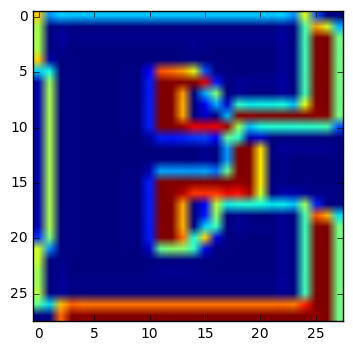

In [6]:
# EXPLORE DATA
# Plot Random Image
RandomImage=TrainDataset[np.random.randint(0,len(TrainDataset))]
plt.imshow(RandomImage)

# Print Size of the Image
print('Size of Image:',RandomImage.shape)

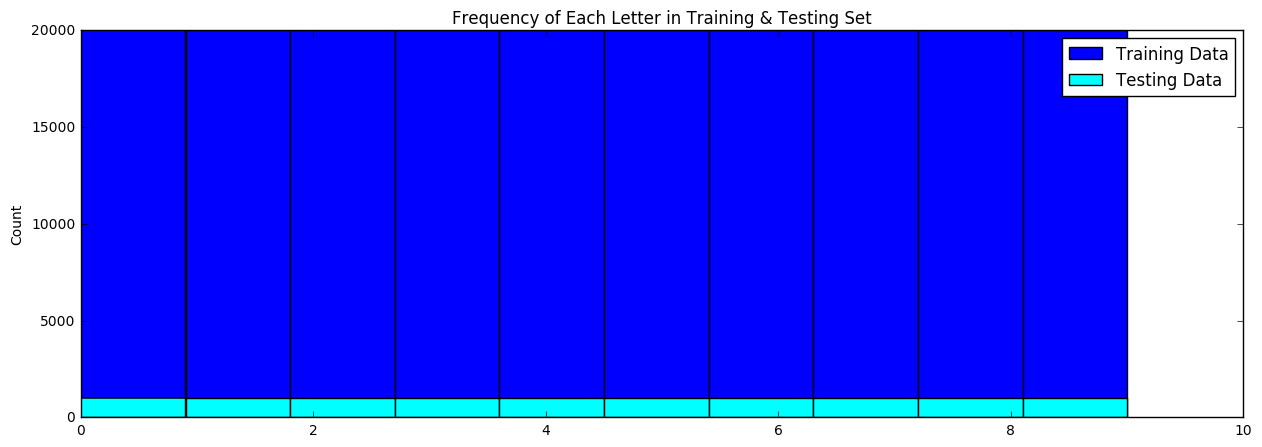

In [7]:
# EXPLORE DATA
# Plot Histogram for Training Dataset Labels
plt.figure(figsize=(15,5))
plt.hist(TrainLabels,bins=NumClass,label='Training Data',color='blue')
plt.hist(TestLabels,bins=NumClass,label='Testing Data',color='cyan')
plt.title('Frequency of Each Letter in Training & Testing Set')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

#### Train, Validate and Test the SVC Model

In [ ]:
# TRAIN & TEST
# Import Modules
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

# Flatten the Data
FlattenTrainDataset=TrainDataset.reshape((TrainSize,28*28))

# Use a Linear SVC 
SVC=LinearSVC()

# Fit Classification Model
SVC.fit(FlattenTrainDataset,TrainLabels)

# Predict using  SVC
SVCPrediction=SVC.predict(TestDataset.reshape(TestSize,28*28))

In [22]:
# TRAIN & TEST
# Confusion Matrix
confusion_matrix(TestLabels,SVCPrediction)

array([[881,   7,   7,   8,  12,  11,   7,  33,  11,  23],
       [  4, 870,   7,  39,  11,  14,  16,  13,  14,  12],
       [  1,   5, 925,   1,  16,  14,  20,   5,  11,   2],
       [  5,  15,   4, 925,   2,   8,   4,   9,  12,  16],
       [  5,  26,  50,   9, 828,  24,  15,   5,  31,   7],
       [  9,   5,   7,   3,   3, 927,   7,   3,  17,  19],
       [ 12,   9,  39,   9,   6,  30, 867,   5,  14,   9],
       [ 31,   9,   6,  11,   9,  14,  16, 874,  20,  10],
       [ 15,   4,   6,  15,  14,  19,   7,  12, 861,  47],
       [ 11,   3,   8,   8,   1,  15,   7,   4,  32, 911]])

In [23]:
# TRAIN & TEST
# Import Modules
from sklearn.metrics import accuracy_score

# Check Accuracy
accuracy_score(TestLabels,SVCPrediction)

0.88690000000000002

#### Train, Validate and Test the LeNet Model

In [8]:
# TRAIN & TEST
# Initial Dataset Shape
print("Training Data Shape:{}".format(TrainDataset.shape))
print("Validation Data Shape:{}".format(ValidDataset.shape))
print("Test Data Shape:{}".format(TestDataset.shape))

# Preprocess Data
XTrain=np.array(TrainDataset).reshape((len(TrainDataset)),28,28,1)
XTrain=np.pad(XTrain,((0,0),(2,2),(2,2),(0,0)),'constant')
YTrain=TrainLabels
XValidation=np.array(ValidDataset).reshape((len(ValidDataset)),28,28,1)
XValidation=np.pad(XValidation,((0,0),(2,2),(2,2),(0,0)),'constant')
YValidation=ValidLabels
XTest=np.array(TestDataset).reshape((len(TestDataset)),28,28,1)
XTest=np.pad(XTest,((0,0),(2,2),(2,2),(0,0)),'constant')
YTest=TestLabels

# Updated Dataset Shape
print("Updated Training Data Shape:{}".format(XTrain.shape))
print("Updated Validation Data Shape:{}".format(XValidation.shape))
print("Updated Test Data Shape:{}".format(XTest.shape))

Training Data Shape:(200000, 28, 28)
Validation Data Shape:(10000, 28, 28)
Test Data Shape:(10000, 28, 28)
Updated Training Data Shape:(200000, 32, 32, 1)
Updated Validation Data Shape:(10000, 32, 32, 1)
Updated Test Data Shape:(10000, 32, 32, 1)


In [9]:
# TRAIN & TEST
# Import Tensorflow
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import time

In [10]:
# DEFINE ARCHITECTURE
# Set Epochs and Batch Size
Epochs=20
BatchSize=128

In [14]:
# DEFINE LENET ARCHITECTURE
def LeNet(X):
    # Set Mu and Sigma 
    Mu=0
    Sigma=0.1
    
    # Layer 01: Convolutional.
    # Input=32x32x1. 
    # Output=28x28x(Feature Number).
    
    # Set Layer 01 Parameters
    Channel=1 
    FeatureNum01=80 
    LocalSize01=5
    
    # Set Layer 01 Network
    W1=tf.Variable(tf.truncated_normal(shape=(LocalSize01,LocalSize01,Channel,FeatureNum01),mean=Mu,stddev=Sigma))
    B1=tf.Variable(tf.zeros(FeatureNum01))
    Conv1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='VALID')+B1
    
    # Set Layer 01 Activation
    Conv1=tf.nn.relu(Conv1)

    # Do Pooling. Input=28x28x(Feature Number). Output=14x14x(Feature Number).
    Conv1=tf.nn.max_pool(Conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

    # Layer 02: Convolutional.
    # Output=10x10x(Feature Number).
    FeatureNum02=120
    LocalSize02=5
    
    # Set Layer 01 Network
    W2=tf.Variable(tf.truncated_normal(shape=(LocalSize02,LocalSize02,FeatureNum01,FeatureNum02),
                                       mean=Mu,stddev=Sigma))
    B2=tf.Variable(tf.zeros(FeatureNum02))
    Conv2=tf.nn.conv2d(Conv1,W2,strides=[1,1,1,1],padding='VALID')+B2
    
    # Set Layer 02 Activation
    Conv2=tf.nn.relu(Conv2)

    # Do Pooling. Input=10x10x(FeatureNumber). Output=5x5x(Feature Number).
    Conv2=tf.nn.max_pool(Conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

    # Perform Flattening. Input=5x5x(Feature Number).
    Flat=flatten(Conv2)
    
    # Layer 03: Fully Connected. 
    # One-Dimensional Input=5x5x(FeatureNumber). One-Dimensional Output=120.
    FeatureNum03=150
    
    # Set Layer 03 Network
    W3=tf.Variable(tf.truncated_normal(shape=(LocalSize02*LocalSize02*FeatureNum02,FeatureNum03),
                                       mean=Mu,stddev=Sigma))
    B3=tf.Variable(tf.zeros(FeatureNum03))
    N3=tf.add(tf.matmul(Flat,W3),B3)
    
    # Set Layer 03 Activation
    N3=tf.nn.relu(N3)

    # Layer 04: Fully Connected.
    # Input=120. Output=80.
    FeatureNum04=80
    
    # Set Layer 04 Network
    W4=tf.Variable(tf.truncated_normal(shape=(FeatureNum03,FeatureNum04),mean=Mu,stddev=Sigma))
    B4=tf.Variable(tf.zeros(FeatureNum04))
    N4=tf.add(tf.matmul(N3,W4),B4)
    
    # Set Layer 04 Activation
    N4=tf.nn.relu(N4)

    # Layer 05: Fully Connected. 
    # Input=84. Output=NumClass.
    OutputNum=10
    
    # Set Layer 05 Network
    W5=tf.Variable(tf.truncated_normal(shape=(FeatureNum04,OutputNum),mean=Mu,stddev=Sigma))
    B5=tf.Variable(tf.zeros(OutputNum))
    Logits=tf.add(tf.matmul(N4,W5),B5)
    
    # Return
    return Logits

In [15]:
# PERFORM TRAINING
# Set Placeholder
X=tf.placeholder(tf.float32,(None,32,32,1))
Y=tf.placeholder(tf.int32,(None))
OneHotY=tf.one_hot(Y,10)
print("Setting Placeholder")

Setting Placeholder


In [16]:
# PERFORM TRAINING
# Set Training Pipeline
Rate=0.001
Logits=LeNet(X)
CrossEntropy=tf.nn.softmax_cross_entropy_with_logits(logits=Logits,labels=OneHotY)
LossOperation=tf.reduce_mean(CrossEntropy)
Optimizer=tf.train.AdamOptimizer(learning_rate=Rate)
TrainingOperation=Optimizer.minimize(LossOperation)
print("Setting Training Pipeline")

Setting Training Pipeline


In [17]:
# MODEL EVALUATION
# Initialize Evaluation
CorrectPrediction=tf.equal(tf.argmax(Logits,1),tf.argmax(OneHotY,1))
AccuracyOperation=tf.reduce_mean(tf.cast(CorrectPrediction,tf.float32))
Saver=tf.train.Saver()

# Define Evaluation 
def Evaluate(XData,YData):
    NumExamples=len(XData)
    TotalAccuracy=0
    Sess=tf.get_default_session()
    for Offset in range(0,NumExamples,BatchSize):
        BatchX,BatchY=XData[Offset:Offset+BatchSize],YData[Offset:Offset+BatchSize]
        Accuracy=Sess.run(AccuracyOperation,feed_dict={X:BatchX,Y:BatchY})
        TotalAccuracy+=(Accuracy*len(BatchX))
    return TotalAccuracy/NumExamples

In [19]:
# TRAIN AND TEST 
# Change Directory
os.chdir('..')

# Use Session to Test Model
with tf.Session() as Sess:
    Sess.run(tf.global_variables_initializer())
    NumExamples=len(XTrain)
    print("Training...")
    for i in range(Epochs):
        XTrain,YTrain=shuffle(XTrain,YTrain)
        for Offset in range(0,NumExamples,BatchSize):
            End=Offset+BatchSize
            BatchX,BatchY=XTrain[Offset:End],YTrain[Offset:End]
            Sess.run(TrainingOperation,feed_dict={X:BatchX,Y:BatchY})       
        ValidationAccuracy=Evaluate(XValidation,YValidation)
        print("Epoch {} ...".format(i+1))
        print("Validation Accuracy={:.3f}".format(ValidationAccuracy)) 
    Saver.save(Sess,'./Model/Lenet')
    print("Model Saved")

Training...
Epoch 1 ...
Validation Accuracy=0.907
Epoch 2 ...
Validation Accuracy=0.912
Epoch 3 ...
Validation Accuracy=0.917
Epoch 4 ...
Validation Accuracy=0.918
Epoch 5 ...
Validation Accuracy=0.922
Epoch 6 ...
Validation Accuracy=0.921
Epoch 7 ...
Validation Accuracy=0.924
Epoch 8 ...
Validation Accuracy=0.923
Epoch 9 ...
Validation Accuracy=0.925
Epoch 10 ...
Validation Accuracy=0.924
Epoch 11 ...
Validation Accuracy=0.923
Epoch 12 ...
Validation Accuracy=0.924
Epoch 13 ...
Validation Accuracy=0.926
Epoch 14 ...
Validation Accuracy=0.925
Epoch 15 ...
Validation Accuracy=0.927
Epoch 16 ...
Validation Accuracy=0.925
Epoch 17 ...
Validation Accuracy=0.926
Epoch 18 ...
Validation Accuracy=0.923
Epoch 19 ...
Validation Accuracy=0.923
Epoch 20 ...
Validation Accuracy=0.925
Model Saved


In [20]:
# EVALUATE ON TEST DATA
# Run Session to Classify Images on Test Data
with tf.Session() as Sess:
    Saver.restore(Sess,'Model/Lenet')
    Classify=Sess.run(AccuracyOperation,feed_dict={X:XTest,Y:YTest})
    print("Test Accuracy={:.3f}".format(Classify))

Test Accuracy=0.971
